# Bayesian Parameter Identification
# Setup Model and FEM (according to E2)

In [1]:
!pip install tqdm

In [2]:
# For better printing within jupyter cells (otherwise only the last variable is printed)
import IPython; IPython.core.interactiveshell.InteractiveShell.ast_node_interactivity = "all"

# Standard python libraries
import os

# General computing libraries
import math
import numpy
import scipy.optimize

# Meshing libraries
import gmsh
import meshio

# Finite element libraries
import dolfin as df
df.parameters["allow_extrapolation"] = True
df.set_log_active(False)

# Plotting libraries
import matplotlib.pyplot as plt
from tqdm import tqdm

# VTK and visualization
import itkwidgets
import vtk

# Tracking libraries
import dolfin_warp as dwarp

# MEC581 python library
import LIB581

In [3]:
def create_mesh(
        X0,                   # first component of the center of the tube, in mm
        Y0,                   # second component of the center of the tube, in mm
        Ri,                   # internal radius of the tube, in mm
        Re,                   # external radius of the tube, in mm
        l,                    # characteristic size of the mesh cells, in mm
        mesh_folder="Project",     # folder the mesh file
        mesh_basename="mesh", # basename of the mesh file
        verbose=False):       # print or not the GMSH output

    ## Initialization of GMSH
    gmsh.initialize()
    if not (verbose): gmsh.option.setNumber("General.Terminal",0)
    gmsh.clear()

    ## Geometry
    factory = gmsh.model.geo

    # Points
    p0 = factory.addPoint(X0, Y0, 0, l) ### YOUR CODE HERE ###
    # 4 points on the inner loop
    p1 = factory.addPoint(X0+Ri, Y0, 0, l)
    p2 = factory.addPoint(X0, Y0+Ri, 0, l)
    p3 = factory.addPoint(X0-Ri, Y0, 0, l)
    p4 = factory.addPoint(X0, Y0-Ri, 0, l)
    # 4 points on the outer loop
    p5 = factory.addPoint(X0+Re, Y0, 0, l)
    p6 = factory.addPoint(X0, Y0+Re, 0, l)
    p7 = factory.addPoint(X0-Re, Y0, 0, l)
    p8 = factory.addPoint(X0, Y0-Re, 0, l)

    # Curves
    # 4 curves for the inner loop
    l11 = factory.addCircleArc(p1, p0, p2) ### YOUR CODE HERE ###
    l12 = factory.addCircleArc(p2, p0, p3)
    l13 = factory.addCircleArc(p3, p0, p4)
    l14 = factory.addCircleArc(p4, p0, p1)
    # 4 curves for the outer loop
    l21 = factory.addCircleArc(p5, p0, p6)
    l22 = factory.addCircleArc(p6, p0, p7)
    l23 = factory.addCircleArc(p7, p0, p8)
    l24 = factory.addCircleArc(p8, p0, p5)
    

    # Curve loop
    cl = factory.addCurveLoop([l11, l12, l13, l14, l21, l22, l23, l24])### YOUR CODE HERE ###

    # Surface
    s = factory.addPlaneSurface([cl]) ### YOUR CODE HERE ###

    # Synchronization, cf., e.g., https://gitlab.onelab.info/gmsh/gmsh/-/blob/master/tutorial/python/t1.py
    factory.synchronize()

    # In order to only save nodes and elements of the final surface
    # (i.e., not the construction points like the circle center,
    # nor the line elements of the line entities—remember that 
    # unstructured meshers will first mesh the curves, then the
    # surfaces and the volumes, cf. MEC552 L5.2), we declare it as a
    # "physical" surface.
    ps = gmsh.model.addPhysicalGroup(dim=2, tags=[s])

    ## Mesh
    mesh_gmsh = gmsh.model.mesh

    # Mesh generation
    mesh_gmsh.generate(dim=2)

    # In order to visualize the mesh and perform finite element computation using
    # FEniCS, we need to convert the mesh from the GMSH format to the VTK & FEniCS
    # formats. Since there is no direct converter between these formats, we do
    # that here by writing the mesh to the disc in VTK format using GMSH, which
    # we can then read in various formats later on.
    if not os.path.exists(mesh_folder): os.mkdir(mesh_folder)
    gmsh.write(mesh_folder+"/"+mesh_basename+".vtk")

    # Finalization of GMSH
    gmsh.finalize()

    # To convert the mesh from vtk to dolfin format,
    # we use [meshio](https://github.com/nschloe/meshio).
    mesh_meshio = meshio.read(mesh_folder+"/"+mesh_basename+".vtk")

    # For 2D meshes, we need to remove the third component of points,
    # otherwise FEniCS believes it is 3D…
    mesh_meshio.points = mesh_meshio.points[:, :2]

    # We write the mesh in XDMF format.
    meshio.write(mesh_folder+"/"+mesh_basename+".xdmf", mesh_meshio)

    # Finaly we can read the mesh in FEniCS format.
    mesh = df.Mesh()
    df.XDMFFile(mesh_folder+"/"+mesh_basename+".xdmf").read(mesh)

    return mesh

# Now we test the function.
mesh = create_mesh(X0=0.5, Y0=0.5, Ri=0.2, Re=0.3, l=0.1/5, verbose=1)

# We check some mesh informations.
print ("geometric_dimension:", mesh.geometric_dimension())
print ("num_vertices:", mesh.num_vertices())
print ("num_cells:", mesh.num_cells())

# We can define "measures", which allow to integrate expressions over (part of) the mesh.
dV = df.Measure("dx", domain=mesh) # "dx" means over the domain itself
mesh_V0 = df.assemble(df.Constant(1.) * dV)
print ("mesh_V0", mesh_V0)

# We visualize the mesh, by writing it to disk in VTK format, reading it,
# and using [itkwidgets](https://github.com/InsightSoftwareConsortium/itkwidgets).
LIB581.write_VTU_file("Project/mesh", mesh)
mesh_vtk = LIB581.read_VTU_file("Project/mesh")
itkwidgets.view(geometries=mesh_vtk)

Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Starting subloop 1 in curve loop 1 (are you sure about this?)
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Circle)
Info    : [ 20%] Meshing curve 2 (Circle)
Info    : [ 30%] Meshing curve 3 (Circle)
Info    : [ 40%] Meshing curve 4 (Circle)
Info    : [ 50%] Meshing curve 5 (Circle)
Info    : [ 70%] Meshing curve 6 (Circle)
Info    : [ 80%] Meshing curve 7 (Circle)
Info    : [ 90%] Meshing curve 8 (Circle)
Info    : Done meshing 1D (Wall 0.00128325s, CPU 0.001421s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.01618s, CPU 0.016579s)
Info    : 575 nodes 1157 elements
Info    : Writing 'Project/mesh.vtk'...
Info    : Done writing 'Project/mesh.vtk'
geometric_dimension: 2
num_vertices: 574
num_cells: 988
mesh_V0 0.1570795786523808


Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [4]:
def create_boundaries(
        X0, Y0, Ri, Re,
        mesh):

    # We create a "MeshFunction",
    # which will allow us to assign an id to each edge of the mesh.

    boundaries_mf = df.MeshFunction(
        value_type="size_t", # size_t is like unisgned int, but more robust with respect to architecture and os
        mesh=mesh,
        dim=1) # 0 for nodes, 1 for edges, 2 for faces, etc.

    # We initialize it to zero.

    boundaries_mf.set_all(0)

    # Now we define geometrical subdomains.

    Si_sd = df.AutoSubDomain(
        lambda x, on_boundary:
            on_boundary and\
            df.near((x[0]-X0)**2+(x[1]-Y0)**2, Ri**2, eps=1e-3))### YOUR CODE HERE ###

    Se_sd = df.AutoSubDomain(
        lambda x, on_boundary:
            on_boundary and\
            df.near((x[0]-X0)**2+(x[1]-Y0)**2, Re**2, eps=1e-3))### YOUR CODE HERE ###

    # And we use the subdomains to mark the different parts of the mesh.

    Si_id = 1; Si_sd.mark(boundaries_mf, Si_id)
    Se_id = 2; Se_sd.mark(boundaries_mf, Se_id)

    return boundaries_mf

# Now we test the function.
X0 = 0.5; Y0 = 0.5; Ri = 0.2; Re = 0.3; l=0.1/3
mesh = create_mesh(X0=X0, Y0=Y0, Ri=Ri, Re=Re, l=l)
boundaries_mf = create_boundaries(X0=X0, Y0=Y0, Ri=Ri, Re=Re, mesh=mesh)

# We can define "measures", which allow to integrate expressions over (part of) the mesh boundary.
dS = df.Measure("ds", domain=mesh, subdomain_data=boundaries_mf) # "ds" means over the domain boundary
mesh_S0 = df.assemble(df.Constant(1) * dS)
print ("mesh_S0", mesh_S0)
Si_id = 1; mesh_Si0 = df.assemble(df.Constant(1) * dS(Si_id))
print ("mesh_Si0", mesh_Si0)
Se_id = 2; mesh_Se0 = df.assemble(df.Constant(1) * dS(Se_id))
print ("mesh_Se0", mesh_Se0)

# We visualize the boundaries.
LIB581.write_VTU_file("Project/boundaries", boundaries_mf)
boundaries_vtk = LIB581.read_VTU_file("Project/boundaries")
itkwidgets.view(geometries=boundaries_vtk)

mesh_S0 3.1394399563914983
mesh_Si0 1.255345531645519
mesh_Se0 1.8840944247459779


Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [5]:
# We can define the finite element function space of the model,
# for instance here with second order Lagrange polynomials,

U_fs = df.VectorFunctionSpace(mesh, "Lagrange", degree=2)
#U_fs.dim()

# as well as the function into which we will store the solution.
# Dolfin functions are very convenient objects, which contain both
# a symbolic representation of the finite element approximation
# (i.e., the linear combination of the shape functions, which we 
# can derive, integrate, etc.) and the array containing the degrees
# of freedom (all the linear algebra is handled by [PETSc](https://www.mcs.anl.gov/petsc),
# which has a pretty ugly website but is one of the most efficient
# open source libraries for linear algebra, though we can also
# manipulate them as numpy arrays for convenience).

U = df.Function(U_fs, name="U")
#U
#df.grad(U)
#U.vector()
#U.vector().get_local()

# We can also define "test" and "trial" functions, which are abstract objects
# used to define linear and bilinear variational forms: a linear form 
# must be linear with respect to the "test" function (which is the U^*
# of the equations); a bilinear form must be linear in both the "test"
# function and "trial" function (which is the U of the equations in the 
# linear setting, the ΔU of the equations in the nonlinear setting, i.e.,
# it is the unknown of the linear problem).

U_test  = df.TestFunction(U_fs)
U_trial = df.TrialFunction(U_fs)

In [6]:
def create_bcs(
        X0, Y0, Ri, Re, U_fs):

    x1 = [X0+Ri, Y0]
    x1_sd = df.AutoSubDomain(
        lambda x, on_boundary: df.near(x[0], x1[0], eps=1e-3) and df.near(x[1], x1[1], eps=1e-3)) #define the subdomains as the 3 points
    x2 = [X0, Y0+Ri]
    x2_sd = df.AutoSubDomain(
        lambda x, on_boundary: df.near(x[0], x2[0], eps=1e-3) and df.near(x[1], x2[1], eps=1e-3))
    x3 = [X0-Ri, Y0]
    x3_sd = df.AutoSubDomain(
        lambda x, on_boundary: df.near(x[0], x3[0], eps=1e-3) and df.near(x[1], x3[1], eps=1e-3))

    bc1 = df.DirichletBC(U_fs.sub(1), 0, x1_sd, "pointwise") # Block first y translation DoF
    bc2 = df.DirichletBC(U_fs.sub(0), 0, x2_sd, "pointwise") # Block first x translation DoF
    bc3 = df.DirichletBC(U_fs.sub(1), 0, x3_sd, "pointwise") # Block translation DoF through second y translation block
    bcs = [bc1, bc2, bc3]

    return bcs

In [7]:
def create_mesh_boundaries_bcs_solution(
        X0, Y0, Ri, Re, l, degree):

    mesh = create_mesh(X0=X0, Y0=Y0, Ri=Ri, Re=Re, l=l)
    boundaries_mf = create_boundaries(X0=X0, Y0=Y0, Ri=Ri, Re=Re, mesh=mesh)
    U_fs = df.VectorFunctionSpace(mesh, "Lagrange", degree=degree)
    bcs = create_bcs(X0=X0, Y0=Y0, Ri=Ri, Re=Re, U_fs=U_fs)
    U = df.Function(U_fs, name="U")

    return mesh, boundaries_mf, bcs, U

In [8]:
def solve_linear_model(mesh, boundaries_mf, bcs, U, Y, nu, P, init_U=None):

    # Virtual work of internal forces
    # (We redefine the parameters as dolfin.Constant,
    #  such that dolfin does not recompile the variational forms
    #  for each value of the parameters.)

    Y     = df.Constant(Y)       # Young modulus (E already used for Green-Lagrange strain)
    nu    = df.Constant(nu)      # Poisson ratio
    lmbda = Y*nu/((1+nu)*(1-2*nu)) # Lamé constant (plane strain) ### YOUR CODE HERE ###
    mu    = Y/(2*(1+nu)) # Lamé constant ### YOUR CODE HERE ###

    U_trial = df.TrialFunction(U.function_space())
    epsilon_trial = df.sym(df.grad(U_trial)) ### YOUR CODE HERE ###
    sigma_trial = lmbda*df.tr(epsilon_trial)*df.Identity(2) + 2*mu*epsilon_trial ### YOUR CODE HERE ###

    U_test = df.TestFunction(U.function_space())
    epsilon_test = df.sym(df.grad(U_test)) ### YOUR CODE HERE ###

    dV = df.Measure("dx", domain=mesh)

    Wint = df.inner(sigma_trial, epsilon_test)*dV ### YOUR CODE HERE ###

    # Virtual work of external forces
    # (We redefine the parameters as dolfin.Constant,
    #  such that dolfin does not recompile the variational forms
    #  for each value of the parameters.)

    P = df.Constant(P)
    N = df.FacetNormal(mesh)
    dS = df.Measure("ds", domain=mesh, subdomain_data=boundaries_mf)
    Si_id = 1

    Wext = -P*df.inner(N, U_test)*dS(Si_id) ### YOUR CODE HERE ###

    # Linear solver

    df.solve(Wint==Wext, U, bcs) ### YOUR CODE HERE ###

In [9]:
def solve_nonlinear_model(mesh, boundaries_mf, bcs, U, Y, nu, P, init_U=None):

    # Kinematics
    # (We define C as a dolfin.variable,
    #  and derive all quantities (including J!) from it,
    #  such that we can later derive the energy with respect to C.)

    I    = df.Identity(2) ### YOUR CODE HERE ### # Identity
    F    = I + df.grad(U) ### YOUR CODE HERE ### # Deformation gradient
    C    = F.T*F ### YOUR CODE HERE ### # Right Cauchy-Green dilatation tensor
    C    = df.variable(C)
    IC   = df.tr(C) ### YOUR CODE HERE ### # First invariant
    IIIC = df.det(C) ### YOUR CODE HERE ### # Third invariant
    J    = df.sqrt(IIIC) ### YOUR CODE HERE ### # Volume ratio
    E    = 0.5*(C - I) ### YOUR CODE HERE ### # Green-Lagrange strain

    # Virtual work of internal forces
    # (We redefine the parameters as dolfin.Constant,
    #  such that dolfin does not recompile the variational forms
    #  for each value of the parameters.)

    Y     = df.Constant(Y)       # Young modulus (E already used for Green-Lagrange strain)
    nu    = df.Constant(nu)      # Poisson ratio
    lmbda = (Y*nu) / ((1.0 + nu)*(1.0 - 2.0*nu)) ### YOUR CODE HERE ### # Lamé constant (plane strain)
    mu    = Y/(2.0*(1.0 + nu)) ### YOUR CODE HERE ### # Lamé constant

    W  = 0.25*lmbda*(J**2 - 1.0 - 2.0*df.ln(J)) ### YOUR CODE HERE ### # Ogden-Ciarlet-Geymonat bulk energy
    W += 0.5*mu*(IC - 3.0 - 2.0*df.ln(J)) ### YOUR CODE HERE ### # Neo-Hookean energy (plane strain)
    Sigma = df.diff(W, C) ### YOUR CODE HERE ###

    U_test = df.TestFunction(U.function_space())
    delta_E = 0.5*(df.grad(U_test).T*F + F.T*df.grad(U_test)) ### YOUR CODE HERE ###

    dV = df.Measure("dx", domain=mesh)

    Wint = df.inner(Sigma, delta_E)*dV ### YOUR CODE HERE ###

    # Virtual work of external forces
    # (We redefine the parameters as dolfin.Constant,
    #  such that dolfin does not recompile the variational forms
    #  for each value of the parameters.)

    P = df.Constant(P)
    N = df.FacetNormal(mesh)
    dS = df.Measure("ds", domain=mesh, subdomain_data=boundaries_mf)
    Si_id = 1

    Wext = -df.dot(P*N, U_test)*dS(Si_id) ### YOUR CODE HERE ###

    # Nonlinear solver
    # (Note that for nonlinear problems solved using the Newton method,
    #  as is the case here, the initial solution of the iterations has a
    #  strong impact on convergence. Thus, we put an additional optional
    #  parameter to the function: if `init_U=True` (the default), the
    #  solution is initialized at 0 before starting the iterations;
    #  conversely, if `init_U=False`, the solution is not initialized,
    #  so the iterations start from the current displacement fields.

    res = Wint - Wext ### YOUR CODE HERE ###

    U_trial = df.TrialFunction(U.function_space())
    jac = df.derivative(res, U, U_trial) ### YOUR CODE HERE ###
    
    if (init_U): U.vector().zero()

    df.solve(res == 0, U, bcs, J=jac) ### YOUR CODE HERE ###

In [10]:
#mesh, boundaries_mf, bcs, U = create_mesh_boundaries_bcs_solution(X0=0.5, Y0=0.5, Ri=0.2, Re=0.3, l=0.1/5, degree=2)
#solve_nonlinear_model(mesh=mesh, boundaries_mf=boundaries_mf, bcs=bcs, U=U, Y=10., nu=0.3, P=+1.)

# To visualize the solution, we save it into the VTK format.
# (The displacement field is applied onto the mesh, which then represents the deformed configuration;
#  you can change the multiplicative factor of the displacement field to better see the deformation.)
#LIB581.write_VTU_file("Project/model", U)
#LIB581.Viewer(meshes="Project/model.vtu").view()

# Bayesian Identification


### Define a distance mesaure

In [11]:
dV = df.Measure("dx", domain=mesh)
def compute_distance(U1, U2, eps=1e-12):
    """
    Computes a dimensionless distance between two displacement fields U1 and U2
    by dividing the L2 error by the L2 norm of U2.
    """
    # L^2 norm of the difference
    diff_L2 = df.sqrt(df.assemble(df.inner(U1 - U2, U1 - U2) * dV))
    
    # L^2 norm of the reference field U2
    ref_L2 = df.sqrt(df.assemble(df.inner(U2, U2) * dV))
    
    # Relative error (avoid division by zero in trivial cases)
    distance = diff_L2 / (ref_L2 + eps)
    return distance

## Single Experiment
### Set-Up

In [12]:
# Setup the simulation (geometry, mesh, boundaries, BCs, function space)
X0, Y0, Ri, Re, l = 0.5, 0.5, 0.2, 0.3, 0.1/5
mesh, boundaries_mf, bcs, U = create_mesh_boundaries_bcs_solution(
    X0=X0, Y0=Y0, Ri=Ri, Re=Re, l=l, degree=2)

# Define “true” parameters
true_Y = 10.0
nu = 0.3
P_obs = 1.0

# Prior for the Young modulus: Uniform over [Y_min, Y_max]
Y_min, Y_max = 5.0, 15.0

# Solve the forward (nonlinear) model with the true Young modulus
# solve_nonlinear_model(mesh=mesh, boundaries_mf=boundaries_mf, bcs=bcs, U=U, Y=true_Y, nu=nu, P=P_obs)
solve_linear_model(mesh=mesh, boundaries_mf=boundaries_mf, bcs=bcs, U=U, Y=true_Y, nu=nu, P=P_obs)


# Save the result as the observed displacement (deep copy the field)
U_obs = df.Function(U.function_space())
U_obs.assign(U)

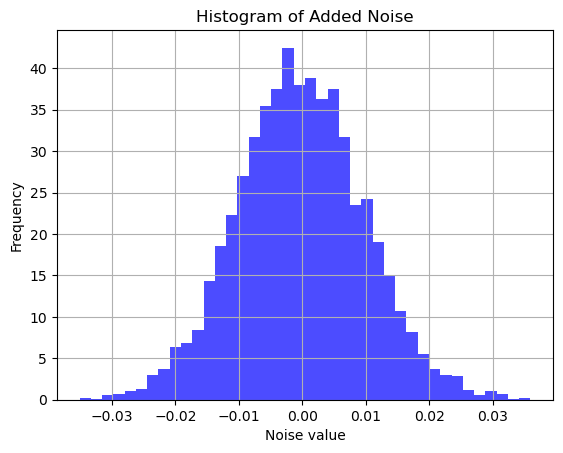

In [13]:
noise_mean = 0
noise_sd = 0.01

# Generate the noise
noise = np.random.normal(loc=noise_mean, scale=noise_sd, 
                         size=U_obs.vector().get_local().shape)

# Add noise to the model the real measurement
U_obs.vector()[:] += noise

# Plot the distribution of the noise
plt.figure();
plt.hist(noise, bins=40, density=True, alpha=0.7, color='blue');
plt.title('Histogram of Added Noise');
plt.xlabel('Noise value');
plt.ylabel('Frequency');
plt.grid(True);
plt.show();

### Setup ABC Rejection Algorithm

In [14]:
def ABC_rejection(U_obs, Y_min, Y_max, N_trials, epsilon, noise_mean, noise_sd):
    accepted_Y = []
    accepted_distances = []

    for i in range(N_trials):
        # Sample Y from the uniform prior
        Y_sample = np.random.uniform(Y_min, Y_max)

        # Solve the forward model with the sampled Young modulus
        # Note: use init_U=True to reinitialize the displacement field at each iteration.
        #solve_nonlinear_model(mesh=mesh, boundaries_mf=boundaries_mf, bcs=bcs, U=U, Y=Y_sample, nu=nu, P=P_obs, init_U=True)
        solve_linear_model(mesh=mesh, boundaries_mf=boundaries_mf, bcs=bcs, U=U, Y=Y_sample, nu=nu, P=P_obs, init_U=True)
        # Generate the noise 
        U.vector()[:] += numpy.random.normal(loc=noise_mean, scale=noise_sd, size=U.vector().get_local().shape)

        # Compute the discrepancy between the current simulation and the observed data
        d = compute_distance(U, U_obs)

        # Accept the sample if the error is below the threshold epsilon
        if d < epsilon:
            accepted_Y.append(Y_sample)
            accepted_distances.append(d)
            #print(f"Accepted {i}: Y_sample = {Y_sample:.3f}, distance = {d:.3f}")
        #else:
            #print(f"Rejected {i}: Y_sample = {Y_sample:.3f}, distance = {d:.3f}")

    #print("Number of accepted samples:", len(accepted_Y))
    
    return accepted_Y, accepted_distances

### Analyse the approximate Posterior

Number of accepted samples: 166/200


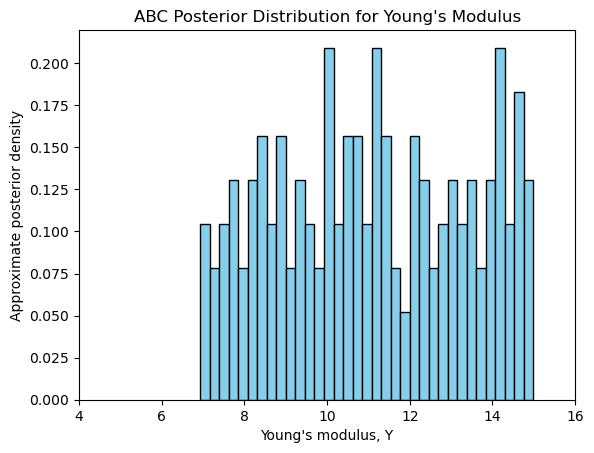

In [15]:
# Number of trials and acceptance threshold (tune epsilon as needed)
N_trials = 200
epsilon = 0.5  # adjust this threshold to control the acceptance rate

accepted_Y, accepted_distances = ABC_rejection(U_obs, Y_min, Y_max, N_trials, epsilon, noise_mean, noise_sd)

print(f"Number of accepted samples: {len(accepted_Y)}/{N_trials}", )

# Plot the histogram of accepted Young modulus values
plt.hist(accepted_Y, bins=35, density=True, color="skyblue", edgecolor="black")
plt.xlabel("Young's modulus, Y")
plt.ylabel("Approximate posterior density")
plt.title("ABC Posterior Distribution for Young's Modulus")
plt.xlim(Y_min-1, Y_max+1)  # Force x-axis to always span from Y_min to Y_max
plt.show();

### Using the weighted si

In [16]:
def ABC_weighted(U_obs, Y_min, Y_max, N_trials, noise_mean, noise_sd):
    # Small constant to avoid division by zero in weights
    eps_w = 1e-3
    
    # Lists to store samples and their weights
    all_samples = []
    all_weights = []

    for i in range(N_trials):
        # Sample Y from the uniform prior
        Y_sample = np.random.uniform(Y_min, Y_max)

        # Solve the forward model with the sampled Young modulus.
        # Use init_U=True to reinitialize the displacement field.
        #solve_nonlinear_model(mesh=mesh, boundaries_mf=boundaries_mf, bcs=bcs, U=U, Y=Y_sample, nu=nu, P=P_obs, init_U=True)
        solve_linear_model(mesh=mesh, boundaries_mf=boundaries_mf, bcs=bcs, U=U, Y=Y_sample, nu=nu, P=P_obs, init_U=True)
        U.vector()[:] += numpy.random.normal(loc=noise_mean, scale=noise_sd, size=U.vector().get_local().shape)


        # Compute the discrepancy between current simulation and observed data
        d = compute_distance(U, U_obs)

        # Compute weight (larger weight for smaller discrepancy)
        weight = 1.0 / (d + eps_w)

        # Store the sample and its weight
        all_samples.append(Y_sample)
        all_weights.append(weight)

        #print(f"Sample {i+1}/{N_trials}: Y = {Y_sample:.3f}, distance = {d:.3f}, weight = {weight:.3f}")

    # Convert lists to numpy arrays for easier manipulation
    all_samples = np.array(all_samples)
    all_weights = np.array(all_weights)

    # Normalize weights to sum to 1 (if desired)
    all_weights_norm = all_weights / np.sum(all_weights)
    
    return all_samples, all_weights_norm

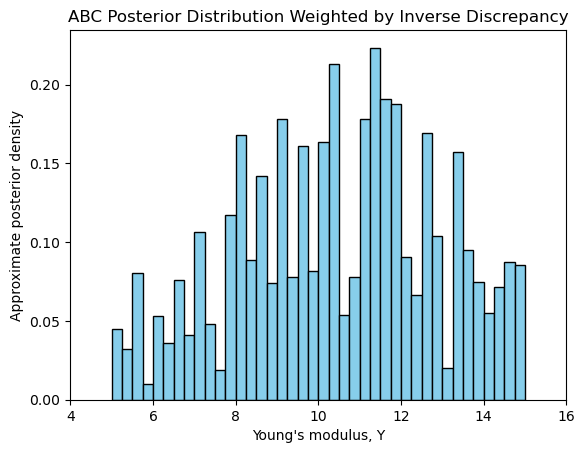

In [17]:
# Number of samples to draw
N_trials = 200

all_samples, all_weights_norm = ABC_weighted(U_obs, Y_min, Y_max, N_trials, noise_mean, noise_sd)

# Plot a weighted histogram of the samples
plt.hist(all_samples, bins=40, density=True, weights=all_weights_norm,
         range=(Y_min, Y_max), color="skyblue", edgecolor="black")
plt.xlabel("Young's modulus, Y")
plt.ylabel("Approximate posterior density")
plt.title("ABC Posterior Distribution Weighted by Inverse Discrepancy")
plt.xlim(Y_min-1, Y_max+1)  # Force x-axis to always span from Y_min to Y_max
plt.show();

### Using half rejection to refine the bounds (as last year)

In [18]:
def ABC_half_rejection_method(U_obs, Y_tilde, eps, N_steps, N_trials, noise_mean, noise_sd):
    # Initial bounds for Young's modulus
    Y_min_ini, Y_max_ini = Y_tilde - eps, Y_tilde + eps 

    eps_w = 1e-6   # Small number to avoid division by zero in weight calculation

    all_Y_samples = []
    all_weights = []

    for n in range(N_steps):
        Y_d_list = []

        #print(f"Sampling from Uniform[{Y_min_ini:.3f}, {Y_max_ini:.3f}]")
        # Sampling and evaluating discrepancy
        for i in range(N_trials):
            # Sample Y from the uniform prior
            Y_sample = np.random.uniform(Y_min_ini, Y_max_ini)

            # Solve the forward model
            solve_linear_model(mesh=mesh, boundaries_mf=boundaries_mf, bcs=bcs, U=U, Y=Y_sample, nu=nu, P=P_obs, init_U=True)
            U.vector()[:] += numpy.random.normal(loc=noise_mean, scale=noise_sd, size=U.vector().get_local().shape)

            
            # Compute the discrepancy between current simulation and observed data
            d_sample = compute_distance(U, U_obs)

            # Compute weight (higher weight for lower discrepancy)
            weight = 1.0 / (d_sample + eps_w)

            # Store the sample and its weight
            all_Y_samples.append(Y_sample)
            all_weights.append(weight)

            # Store for updating bounds
            Y_d_list.append((Y_sample, d_sample))

            #print(f"Sample {i+1}/{N_trials}: Y = {Y_sample:.3f}, distance = {d_sample:.6f}, weight = {weight:.6f}")

        # Sort samples by discrepancy (ascending)
        Y_d_list.sort(key=lambda x: x[1])

        # Select the best 50% samples (half with the lowest d values)
        top_half = Y_d_list[:N_trials // 2]

        # Update Y_min_ini and Y_max_ini to the range of the selected top samples
        Y_min_ini = min(y for y, _ in top_half)
        Y_max_ini = max(y for y, _ in top_half)

        #print(f"Updated bounds after Step {n+1}: Y_min = {Y_min_ini:.3f}, Y_max = {Y_max_ini:.3f}")
        
    # Convert lists to numpy arrays
    all_Y_samples = np.array(all_Y_samples)
    all_weights = np.array(all_weights)

    # Normalize weights safely
    weight_sum = np.sum(all_weights)
    if weight_sum > 0:
        all_weights_norm = all_weights / weight_sum
    else:
        all_weights_norm = all_weights

    return all_Y_samples, all_weights_norm

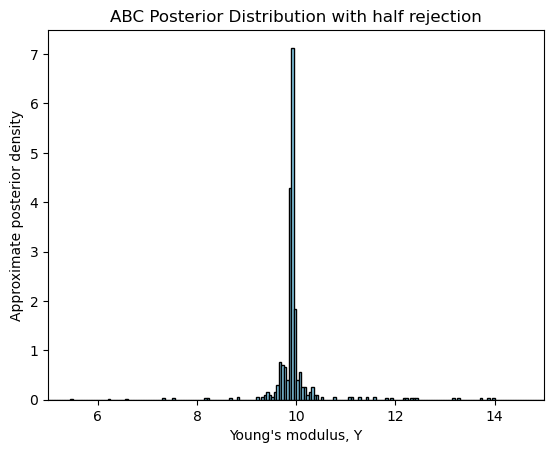

In [19]:
Y_tilde = 10
eps = 5
N_steps = 20
N_trials = 20

all_Y_samples, all_weights_norm = ABC_half_rejection_method(U_obs, Y_tilde, eps, N_steps, N_trials, noise_mean, noise_sd)
        
# Plot a weighted histogram of the samples
plt.hist(all_Y_samples, bins=200, density=True, weights=all_weights_norm,
         range=(Y_tilde - eps, Y_tilde + eps), color="skyblue", edgecolor="black")

plt.xlabel("Young's modulus, Y")
plt.ylabel("Approximate posterior density")
plt.title("ABC Posterior Distribution with half rejection")
plt.xlim(Y_tilde - eps, Y_tilde + eps)  # Force x-axis to always span from Y_min_ini to Y_max_ini
plt.show();

## Multiple Experiments - true_Y stays the same

Here, we simulate the setting that you have a specimen but do multiple different experiments on it. You want to find the singe parameter for this specimen without the measurement noise.

Should converge to a dirac that represents the parameter for this singe specimen that you ran multiple experiments on

In [20]:
# Prior for the Young modulus: Uniform over [Y_min, Y_max]
Y_min, Y_max = 5.0, 15.0

# Use the same Y but with noise for the different experiments
Y_true = 10
noise_mean = 0
noise_sd = 0.01

### With epsilon rejection of samples

In [21]:
# Number of experiments to run
n_experiments = 2
N_trials = 100
epsilon = 0.5  # acceptance threshold

# Storage for results from all experiments
all_experiment_accepted_Y = []

# Run multiple experiments
for exp in tqdm(range(n_experiments), ncols= 100):
    # Generate the noise
    noise = np.random.normal(loc=noise_mean, scale=noise_sd, size=U_obs.vector().get_local().shape)
    
    # Generate synthetic observation with this Y_true
    solve_linear_model(mesh=mesh, boundaries_mf=boundaries_mf, bcs=bcs, U=U, 
                      Y=Y_true, nu=nu, P=P_obs)
    U_obs = df.Function(U.function_space())
    U_obs.assign(U)
    
    # Add noise to the model the real measurement
    U_obs.vector()[:] += noise
    
    # Run ABC for this observation
    accepted_Y, _ = ABC_rejection(U_obs, Y_min, Y_max, N_trials, epsilon, noise_mean, noise_sd)

    #print(f"Experiment {exp+1} finished with {len(accepted_Y)} accepted samples")
    all_experiment_accepted_Y.append(np.array(accepted_Y))


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:16<00:00,  8.45s/it]


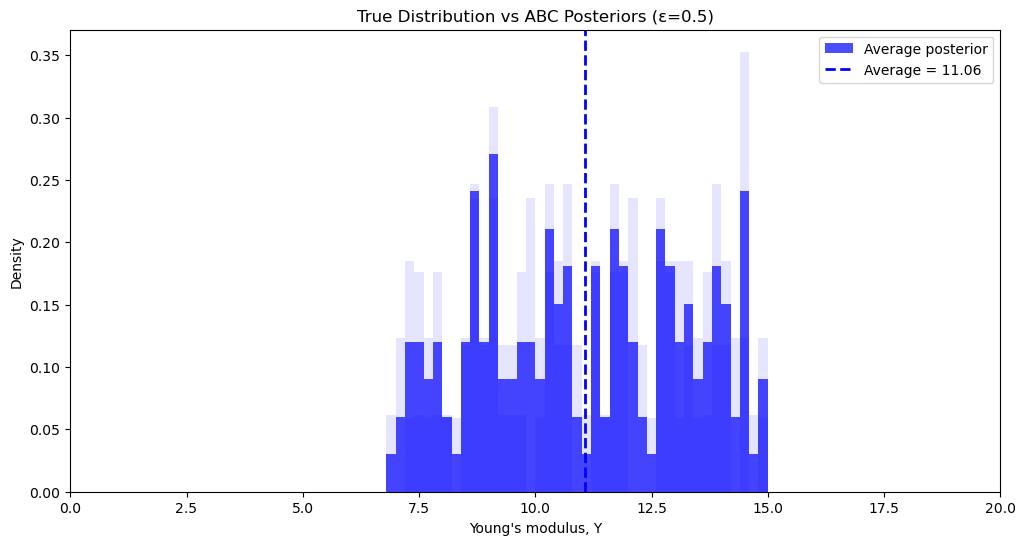


Summary Statistics:
Total number of experiments: 2
Average number of accepted samples per experiment: 83.0/100
Total number of accepted samples: 166


In [22]:
# Plot results
bins = 50
fig = plt.figure(figsize=(12, 6));
# Plot the true Y distribution
#y_range = np.linspace(Y_min, Y_max, 100)
#plot = plt.plot(y_range, true_Y_dist.pdf(y_range), 'r-', label='True Y distribution', linewidth=2);

# Plot individual experiment posteriors (semi-transparent)
for accepted_Y in all_experiment_accepted_Y:
    if len(accepted_Y) > 0:  # Only plot if there are accepted samples
        hist = plt.hist(accepted_Y, bins=bins, density=True,
                alpha=0.1, color='blue', range=(Y_min, Y_max));

# Plot average posterior
combined_accepted_Y = np.concatenate([Y for Y in all_experiment_accepted_Y if len(Y) > 0])
if len(combined_accepted_Y) > 0:
    hist = plt.hist(combined_accepted_Y, bins=bins, density=True,
             alpha=0.7, color='blue', range=(Y_min, Y_max),
             label='Average posterior');
    
    # Calculate the average (mean) of the posterior
    average_posterior = np.mean(combined_accepted_Y)

    # Plot the average posterior as a vertical line
    line = plt.axvline(average_posterior, color='blue', linestyle='dashed', linewidth=2, label=f'Average = {average_posterior:.2f}')


xlabel = plt.xlabel("Young's modulus, Y");
ylabel = plt.ylabel("Density");
tite = plt.title(f"True Distribution vs ABC Posteriors (ε={epsilon})");
legend = plt.legend();
slim = plt.xlim(Y_min-5, Y_max+5);
plt.show();

# Print some statistics
print("\nSummary Statistics:")
print(f"Total number of experiments: {n_experiments}")
print(f"Average number of accepted samples per experiment: {np.mean([len(Y) for Y in all_experiment_accepted_Y]):.1f}/{N_trials}")
print(f"Total number of accepted samples: {len(combined_accepted_Y)}")

### With Distance based weighing of samples

In [23]:
# Number of experiments & trials to run
n_experiments = 2
N_trials = 100

# Storage for results from all experiments
all_experiment_samples = []
all_experiment_weights = []

# Run multiple experiments
for exp in tqdm(range(n_experiments), ncols= 100):
    # Generate the noise
    noise = np.random.normal(loc=noise_mean, scale=noise_sd, size=U_obs.vector().get_local().shape)
    
    # Generate synthetic observation with this Y_true
    solve_linear_model(mesh=mesh, boundaries_mf=boundaries_mf, bcs=bcs, U=U, 
                      Y=Y_true, nu=nu, P=P_obs)
    U_obs = df.Function(U.function_space())
    U_obs.assign(U)
    
    # Add noise
    U_obs.vector()[:] += noise

    all_samples, all_weights_norm = ABC_weighted(U_obs, Y_min, Y_max, N_trials, noise_mean, noise_sd)
    
    # Store results
    all_experiment_samples.append(np.array(all_samples))
    all_experiment_weights.append(all_weights_norm)


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:16<00:00,  8.48s/it]


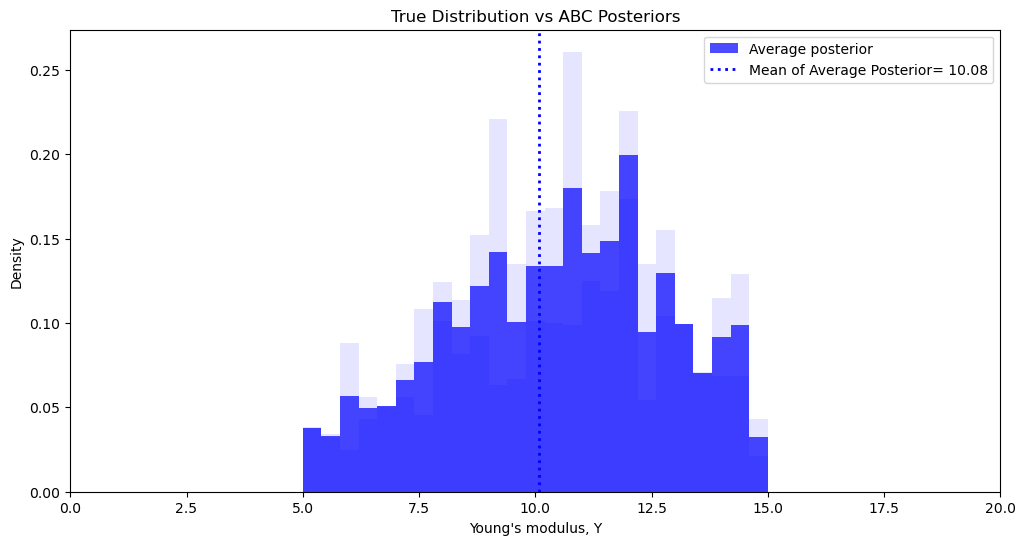

In [24]:
# Plot results
plt.figure(figsize=(12, 6))
bins = 25

# Plot individual experiment posteriors (semi-transparent)
for samples, weights in zip(all_experiment_samples, all_experiment_weights):
    plt.hist(samples, bins=bins, density=True, weights=weights,
             alpha=0.1, color='blue', range=(Y_min, Y_max))

# Plot average posterior
combined_samples = np.concatenate(all_experiment_samples)
combined_weights = np.concatenate(all_experiment_weights) / n_experiments
plt.hist(combined_samples, bins=bins, density=True, weights=combined_weights,
         alpha=0.7, color='blue', range=(Y_min, Y_max),
         label='Average posterior')

# Calculate and plot the mean of the average posterior as a dotted line
mean_posterior = np.mean(combined_samples)
plt.axvline(mean_posterior, color='blue', linestyle='dotted', linewidth=2, label=f'Mean of Average Posterior= {mean_posterior:.2f}')


plt.xlabel("Young's modulus, Y")
plt.ylabel("Density")
plt.title("True Distribution vs ABC Posteriors")
plt.legend()
plt.xlim(Y_min-5, Y_max+5)
plt.show();


### Smarter Bounding (as last year)

Reducing the bounds of epsilon progressively

In [25]:
# Number of experiments & trials to run
n_experiments = 2
Y_tilde = 10
eps = 5
N_steps = 10
N_trials = 10

# Storage for results from all experiments
all_experiment_samples = []
all_experiment_weights = []

# Run multiple experiments
for exp in tqdm(range(n_experiments), ncols= 100):   
    # Generate the noise
    noise = np.random.normal(loc=noise_mean, scale=noise_sd, size=U_obs.vector().get_local().shape)
    
    # Generate synthetic observation with this Y_true
    solve_linear_model(mesh=mesh, boundaries_mf=boundaries_mf, bcs=bcs, U=U, 
                      Y=Y_true, nu=nu, P=P_obs)
    U_obs = df.Function(U.function_space())
    U_obs.assign(U)
    
    # Add noise
    U_obs.vector()[:] += noise
    
    # Run ABC for this observation
    all_Y_samples, all_weights_norm = ABC_half_rejection_method(U_obs, Y_tilde, eps, N_steps, N_trials, noise_mean, noise_sd)
    
    # Store results
    all_experiment_samples.append(all_Y_samples)
    all_experiment_weights.append(all_weights_norm)
    

100%|█████████████████████████████████████████████████████████████████| 2/2 [00:17<00:00,  8.51s/it]


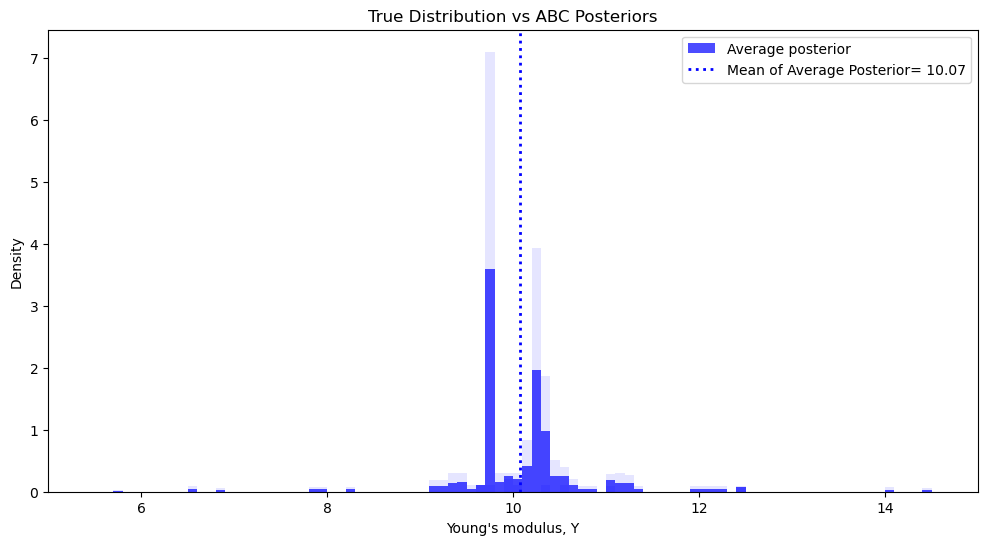

In [26]:
# Plot results
plt.figure(figsize=(12, 6))
bins = 100

# Plot individual experiment posteriors (semi-transparent)
for samples, weights in zip(all_experiment_samples, all_experiment_weights):
    plt.hist(samples, bins=bins, density=True, weights=weights,
             alpha=0.1, color='blue', range=(Y_min, Y_max))

# Plot average posterior
combined_samples = np.concatenate(all_experiment_samples)
combined_weights = np.concatenate(all_experiment_weights) / n_experiments
plt.hist(combined_samples, bins=bins, density=True, weights=combined_weights,
         alpha=0.7, color='blue', range=(Y_min, Y_max),
         label='Average posterior')

# Calculate and plot the mean of the average posterior as a dotted line
mean_posterior = np.mean(combined_samples)
plt.axvline(mean_posterior, color='blue', linestyle='dotted', linewidth=2, label=f'Mean of Average Posterior= {mean_posterior:.2f}')


plt.xlabel("Young's modulus, Y")
plt.ylabel("Density")
plt.title("True Distribution vs ABC Posteriors")
plt.legend()
plt.xlim(Y_min, Y_max)
plt.show();

## Multiple Experiments - true_Y also follows a distribution

Here, we simulate that you have multiple specimen that might be similar. You still run multiple experiments, but only one per specimen. You want to find the distribution of the parameter for this sample of specimen without the measurement noise.

Should converge to the distribution of the Parameters of all the specimen.

We sample measurements (experiments) from a normal distribution and compute their "measured" displacement. Then we do the ABC Algorithm by drawing the Y's from a uniform distribution, and weigh them by their calculated displacements inverse distance to the measurements displacement. Then, we average over all the experiments. There might need to be a better method to combine all the different distributions of the individual specimen

In [27]:
# Define the distribution for true_Y
# Let's say it's a normal distribution with mean=10 and std=1, truncated to [Y_min, Y_max]
from scipy.stats import truncnorm

# Parameters for the true Y distribution
Y_true_mean = 10.0
Y_true_std = 1.0
a = (Y_min - Y_true_mean) / Y_true_std  # For truncated normal
b = (Y_max - Y_true_mean) / Y_true_std
true_Y_dist = truncnorm(a, b, loc=Y_true_mean, scale=Y_true_std)

# Prior for the Young modulus: Uniform over [Y_min, Y_max]
Y_min, Y_max = 5.0, 15.0

# Generate the noise
noise_mean = 0
noise_sd = 0.01

### With epsilon rejection of samples

In [28]:
# Number of experiments to run
n_experiments = 2
N_trials = 100
epsilon = 0.5  # acceptance threshold

# Storage for results from all experiments
all_experiment_accepted_Y = []

# Run multiple experiments
for exp in tqdm(range(n_experiments), ncols= 100):
    # Draw a true Y value for this experiment
    true_Y = true_Y_dist.rvs()
    
    # Generate the noise
    noise = np.random.normal(loc=noise_mean, scale=noise_sd, size=U_obs.vector().get_local().shape)
    
    # Generate synthetic observation with this true_Y
    solve_linear_model(mesh=mesh, boundaries_mf=boundaries_mf, bcs=bcs, U=U, 
                      Y=true_Y, nu=nu, P=P_obs)
    U_obs = df.Function(U.function_space())
    U_obs.assign(U)
    
    # Add noise to the model the real measurement
    U_obs.vector()[:] += noise
    
    # Run ABC for this observation
    accepted_Y, _ = ABC_rejection(U_obs, Y_min, Y_max, N_trials, epsilon, noise_mean, noise_sd)

    #print(f"Experiment {exp+1} finished with {len(accepted_Y)} accepted samples")
    all_experiment_accepted_Y.append(np.array(accepted_Y))


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:17<00:00,  8.60s/it]


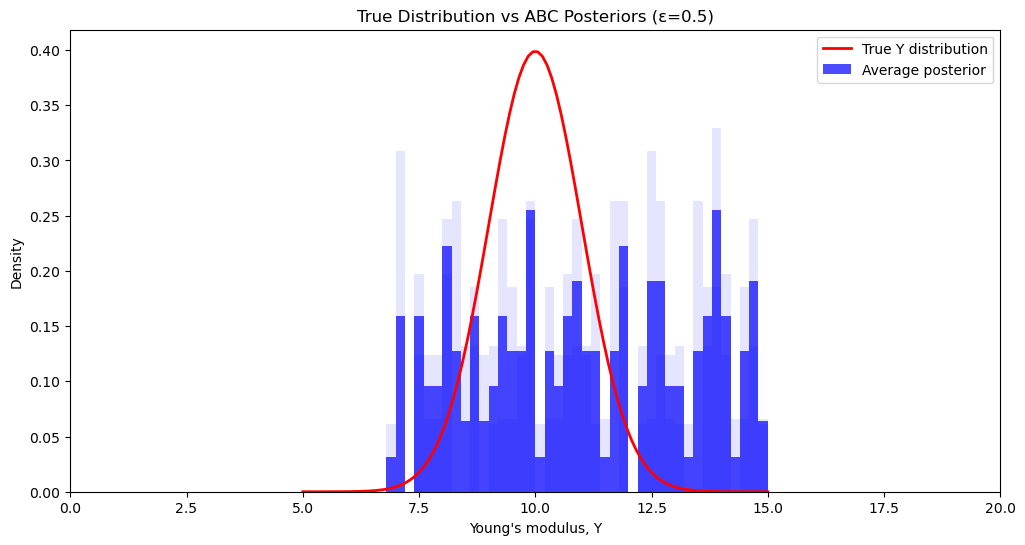


Summary Statistics:
Total number of experiments: 2
Average number of accepted samples per experiment: 78.5/100
Total number of accepted samples: 157


In [29]:
# Plot results
bins = 50
fig = plt.figure(figsize=(12, 6));
# Plot the true Y distribution
y_range = np.linspace(Y_min, Y_max, 100)
plot = plt.plot(y_range, true_Y_dist.pdf(y_range), 'r-', label='True Y distribution', linewidth=2);

# Plot individual experiment posteriors (semi-transparent)
for accepted_Y in all_experiment_accepted_Y:
    if len(accepted_Y) > 0:  # Only plot if there are accepted samples
        hist = plt.hist(accepted_Y, bins=bins, density=True,
                alpha=0.1, color='blue', range=(Y_min, Y_max));

# Plot average posterior
combined_accepted_Y = np.concatenate([Y for Y in all_experiment_accepted_Y if len(Y) > 0])
if len(combined_accepted_Y) > 0:
    hist = plt.hist(combined_accepted_Y, bins=bins, density=True,
             alpha=0.7, color='blue', range=(Y_min, Y_max),
             label='Average posterior');

xlabel = plt.xlabel("Young's modulus, Y");
ylabel = plt.ylabel("Density");
tite = plt.title(f"True Distribution vs ABC Posteriors (ε={epsilon})");
legend = plt.legend();
slim = plt.xlim(Y_min-5, Y_max+5);
plt.show();

# Print some statistics
print("\nSummary Statistics:")
print(f"Total number of experiments: {n_experiments}")
print(f"Average number of accepted samples per experiment: {np.mean([len(Y) for Y in all_experiment_accepted_Y]):.1f}/{N_trials}")
print(f"Total number of accepted samples: {len(combined_accepted_Y)}")

### With Distance based weighing of samples

In [30]:
# Number of experiments & trials to run
n_experiments = 2
N_trials = 100

# Storage for results from all experiments
all_experiment_samples = []
all_experiment_weights = []

# Run multiple experiments
for exp in tqdm(range(n_experiments), ncols= 100):
    # Draw a true Y value for this experiment
    true_Y = true_Y_dist.rvs()

    # Generate the noise
    noise = np.random.normal(loc=noise_mean, scale=noise_sd, size=U_obs.vector().get_local().shape)
    
    # Generate synthetic observation with this true_Y
    solve_linear_model(mesh=mesh, boundaries_mf=boundaries_mf, bcs=bcs, U=U, 
                      Y=true_Y, nu=nu, P=P_obs)
    U_obs = df.Function(U.function_space())
    U_obs.assign(U)
    
    # Add noise
    U_obs.vector()[:] += noise

    
    # Run ABC for this observation
    all_samples, all_weights_norm = ABC_weighted(U_obs, Y_min, Y_max, N_trials, noise_mean, noise_sd)
    
    # Store results
    all_experiment_samples.append(np.array(all_samples))
    all_experiment_weights.append(all_weights_norm)


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:16<00:00,  8.42s/it]


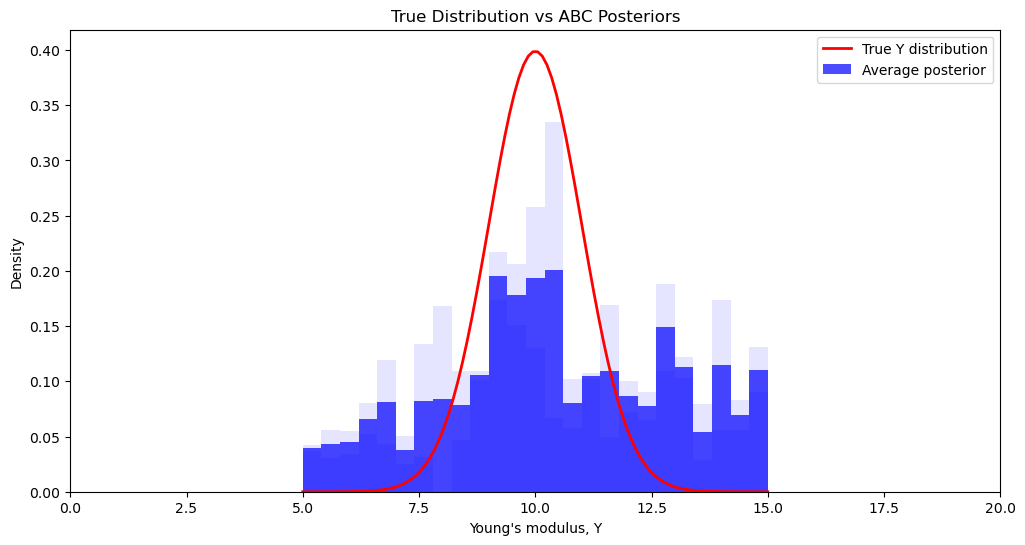

In [31]:
# Plot results
plt.figure(figsize=(12, 6))
bins = 25

# Plot the true Y distribution
y_range = np.linspace(Y_min, Y_max, 100)
plt.plot(y_range, true_Y_dist.pdf(y_range), 'r-', label='True Y distribution', linewidth=2)

# Plot individual experiment posteriors (semi-transparent)
for samples, weights in zip(all_experiment_samples, all_experiment_weights):
    plt.hist(samples, bins=bins, density=True, weights=weights,
             alpha=0.1, color='blue', range=(Y_min, Y_max))

# Plot average posterior
combined_samples = np.concatenate(all_experiment_samples)
combined_weights = np.concatenate(all_experiment_weights) / n_experiments
plt.hist(combined_samples, bins=bins, density=True, weights=combined_weights,
         alpha=0.7, color='blue', range=(Y_min, Y_max),
         label='Average posterior')

plt.xlabel("Young's modulus, Y")
plt.ylabel("Density")
plt.title("True Distribution vs ABC Posteriors")
plt.legend()
plt.xlim(Y_min-5, Y_max+5)
plt.show();


### Smarter Bounding (as last year)

Reducing the bounds of epsilon progressively

In [32]:
# Number of experiments & trials to run
n_experiments = 2
Y_tilde = 10
eps = 5
N_steps = 10
N_trials = 10

# Storage for results from all experiments
all_experiment_samples = []
all_experiment_weights = []

# Run multiple experiments
for exp in tqdm(range(n_experiments), ncols= 100):
    # Draw a true Y value for this experiment
    true_Y = true_Y_dist.rvs()
    
    # Generate the noise
    noise = np.random.normal(loc=noise_mean, scale=noise_sd, size=U_obs.vector().get_local().shape)
    
    # Generate synthetic observation with this true_Y
    solve_linear_model(mesh=mesh, boundaries_mf=boundaries_mf, bcs=bcs, U=U, 
                      Y=true_Y, nu=nu, P=P_obs)
    U_obs = df.Function(U.function_space())
    U_obs.assign(U)
    
    # Add noise
    U_obs.vector()[:] += noise
    
    # Run ABC for this observation
    all_Y_samples, all_weights_norm = ABC_half_rejection_method(U_obs, Y_tilde, eps, N_steps, N_trials, noise_mean, noise_sd)
    
    # Store results
    all_experiment_samples.append(all_Y_samples)
    all_experiment_weights.append(all_weights_norm)
    

100%|█████████████████████████████████████████████████████████████████| 2/2 [00:17<00:00,  8.61s/it]


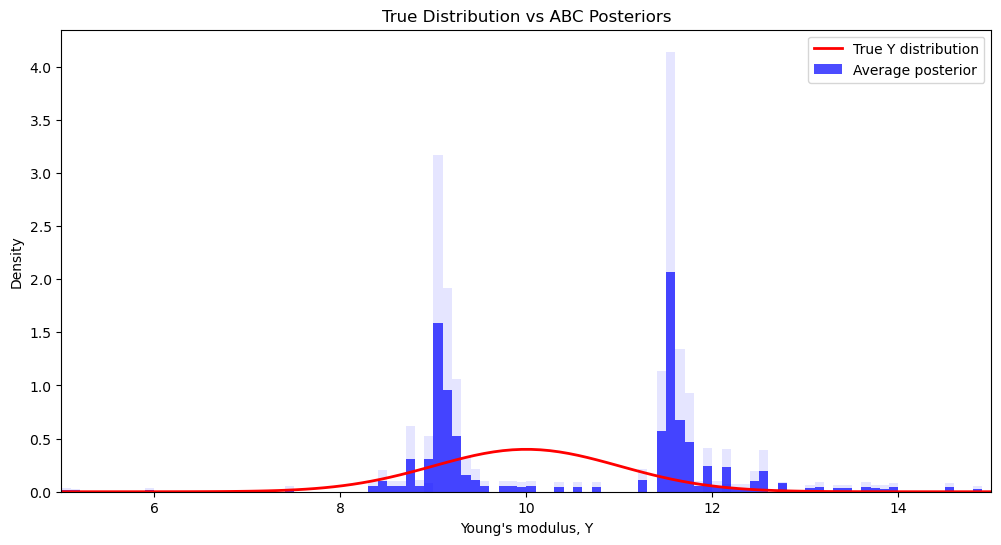

In [33]:
# Plot results
plt.figure(figsize=(12, 6))
bins = 100

# Plot the true Y distribution
y_range = np.linspace(Y_min, Y_max, 100)
plt.plot(y_range, true_Y_dist.pdf(y_range), 'r-', label='True Y distribution', linewidth=2)

# Plot individual experiment posteriors (semi-transparent)
for samples, weights in zip(all_experiment_samples, all_experiment_weights):
    plt.hist(samples, bins=bins, density=True, weights=weights,
             alpha=0.1, color='blue', range=(Y_min, Y_max))

# Plot average posterior
combined_samples = np.concatenate(all_experiment_samples)
combined_weights = np.concatenate(all_experiment_weights) / n_experiments
plt.hist(combined_samples, bins=bins, density=True, weights=combined_weights,
         alpha=0.7, color='blue', range=(Y_min, Y_max),
         label='Average posterior')

plt.xlabel("Young's modulus, Y")
plt.ylabel("Density")
plt.title("True Distribution vs ABC Posteriors")
plt.legend()
plt.xlim(Y_min, Y_max)
plt.show();